In [1]:
from activ import load_data, data_normalization
import os
from activ.readfile import TrackTBIFile
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap
from activ.clustering import UmapClusteringResults
import activ.nmf.viz as nmfviz
from os.path import dirname, join
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Latex, Markdown
from pylatex import Document, Section, Subsection, Command
from pylatex import Document, Section, Figure, SubFigure, NoEscape
from pylatex.utils import italic, NoEscape
from scipy.stats import norm, sem
import scipy.optimize as spo

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [3]:
def accuracy(mat):
    return mat.trace()/mat.sum()

In [4]:
path = "../results/no_transform/bm_drop_0_result.h5"

In [20]:
# all outcomes and biomarkers

f = h5py.File(path, 'r')
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc


plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.array([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.array([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)

raw_med = np.median(raw_acc, axis=1)
raw_lower = np.array([np.percentile(raw_acc[i,:], 25) for i in range(49)])
raw_upper = np.array([np.percentile(raw_acc[i,:], 75) for i in range(49)])
norm_med = np.median(normalized_acc, axis=1)
norm_lower = np.array([np.percentile(normalized_acc[i,:], 25) for i in range(49)])
norm_upper = np.array([np.percentile(normalized_acc[i,:], 75) for i in range(49)])

Text(0,0.5,'Fold over chance')

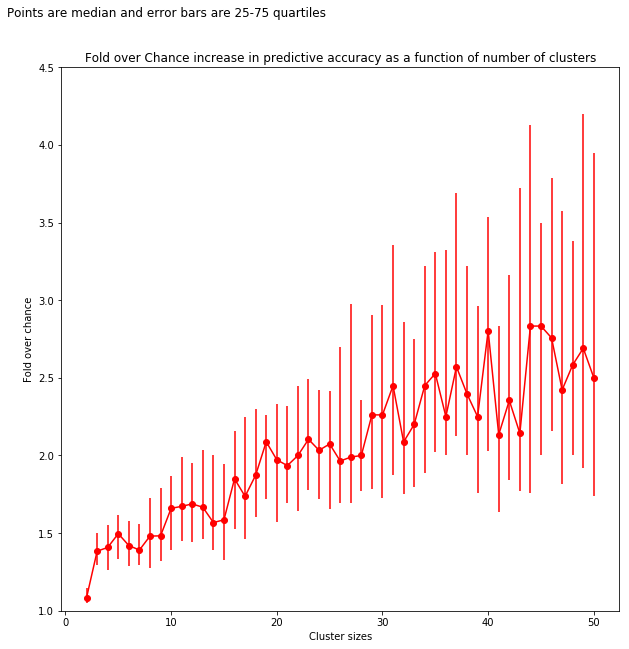

In [21]:
fig = plt.figure(figsize=[10,10])
plt.ylim((1, 4.5))
plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')
plt.title("Fold over Chance increase in predictive accuracy as a function of number of clusters")
txt = "Points are median and error bars are 25-75 quartiles"
plt.text(0.05,0.95,txt, transform=fig.transFigure, size=12)
plt.xlabel("Cluster sizes")
plt.ylabel("Fold over chance")
#plt.legend()
#plt.savefig("%s.pdf" % join(dirname(path, ))

Text(0.05,0.95,'Points are median and error bars are 25-75 quartiles')

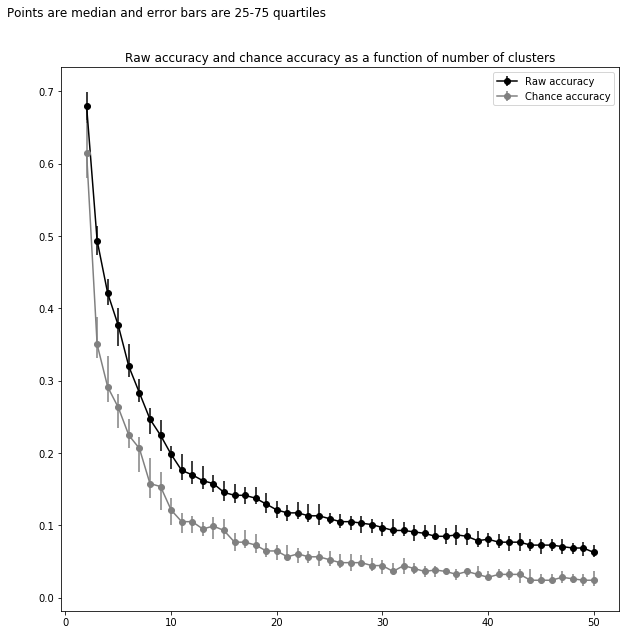

In [22]:
fig = plt.figure(figsize=[10,10])
plt.errorbar(cluster_sizes, raw_med, yerr=[raw_med-raw_lower,raw_upper-raw_med], color='black',fmt='-o', label='Raw accuracy')
plt.errorbar(cluster_sizes, norm_med, yerr=[norm_med-norm_lower, norm_upper-norm_med], color='grey',fmt='-o', label='Chance accuracy')
plt.legend()
plt.title("Raw accuracy and chance accuracy as a function of number of clusters")
txt = "Points are median and error bars are 25-75 quartiles"
plt.text(0.05,0.95,txt, transform=fig.transFigure, size=12)

In [5]:
from activ import load_data
nmf = load_data(uoinmf=True)
raw = load_data(uoinmf=False)
bm = nmf.biomarkers
oc = nmf.outcomes
print(bm.shape[1], "biomarker features")
print(oc.shape[1], "outcome features")

6 biomarker features
6 outcome features


In [6]:
[(i, x) for i, x in enumerate(raw.outcome_features) if 'GOSE_Overall' in x]

[(4, 'GOSE_OverallScore3M'), (32, 'GOSE_OverallScore6M')]

In [7]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)
bm_cca, oc_cca = cca.fit_transform(bm, oc)

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
# CCA with Rsquared of step function, and step function
depth = np.arange(1,16, dtype=int)
rsqs = np.zeros(len(depth), dtype=float)
mses = np.zeros(len(depth), dtype=float)
y_true = oc_cca.ravel()
for i, d in enumerate(depth):
    y_pred = cross_val_predict(RandomForestRegressor(max_depth=d, n_estimators=200, random_state=3), bm_cca, y_true, cv=5)
    rsqs[i] = r2_score(oc_cca, y_pred)
    mses[i] = mean_squared_error(y_true, y_pred)

In [9]:
rf = RandomForestRegressor(max_depth=2, n_estimators=200).fit(bm_cca, oc_cca.ravel())
xfit = np.linspace(min(bm_cca),max(bm_cca), 1000).reshape((1000,1))
yfit = rf.predict(xfit)
print(r2_score(oc_cca, rf.predict(bm_cca)))

0.33069844390273995


Text(0,-3,'$R^2$ = 0.192066')

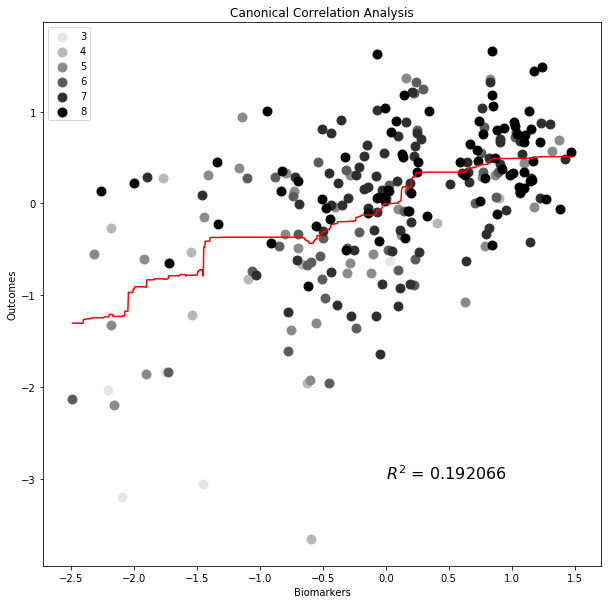

In [10]:
oc_col = raw.outcomes[:,4]
cm = plt.cm.get_cmap('gray')
colors = [cm(val) for val in np.linspace(0.0, 0.9, len(np.unique(oc_col)))]
colors = colors[::-1]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
for i, gose in enumerate(np.unique(oc_col)):
    idx = oc_col == gose
    sc = ax.scatter(bm_cca[idx], oc_cca[idx], c=colors[i], label=int(gose), s=80, facecolors='none')
plt.legend(loc='upper left')
plt.plot(xfit, yfit, color='red')
plt.xlabel("Biomarkers")
plt.ylabel("Outcomes")
plt.title("Canonical Correlation Analysis")
plt.text(0, -3, "$R^2$ = %0.6f" % max(rsqs), size=16)
# plt.savefig("/Users/ahyeon/Desktop/activ misc/CCA_r2_onplot.pdf")

## BOKEH

In [79]:
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

Loading BokehJS ...

In [80]:
from ipywidgets import interact
import ipywidgets as widgets
from bokeh.layouts import row, widgetbox, column
from bokeh.models import Select, ColumnDataSource
from bokeh.palettes import Greys8
from bokeh.plotting import curdoc, figure
from bokeh.sampledata.autompg import autompg_clean as df

In [81]:
import pandas as pd
columns = ['bm_cca', 'oc_cca', 'gose_3', 'gose_6']
df = pd.DataFrame(columns=columns)

In [82]:
bm_cca = bm_cca.ravel()
oc_cca = oc_cca.ravel()

In [83]:
df['bm_cca'] = bm_cca
df['oc_cca'] = oc_cca
df['gose_3'] = raw.outcomes[:,4].astype(int)
df['gose_6'] = raw.outcomes[:,32].astype(int)

In [84]:
df = df.copy()

In [95]:
SIZES = list(range(6, 22, 3))
COLORS = Greys8[::-1]
N_SIZES = len(SIZES)
N_COLORS = len(COLORS)
scores = ['3', '4', '5', '6', '7', '8']

In [96]:
COLORS

['#ffffff',
 '#f0f0f0',
 '#d9d9d9',
 '#bdbdbd',
 '#969696',
 '#737373',
 '#525252',
 '#252525']

In [87]:
xs = df['bm_cca'].values
xs3 = df[df['gose_3']==3]
xs3_new = xs3['bm_cca'].values
print(xs3)
print(xs3_new)

       bm_cca    oc_cca  gose_3  gose_6
28  -2.212360 -2.037118       3       3
42  -2.097405 -3.201969       3       3
45  -1.752672 -1.833708       3       5
68  -1.456278 -3.053197       3       4
138  0.033538 -0.627626       3       4
[-2.2123603  -2.0974046  -1.75267161 -1.4562776   0.03353805]


In [91]:
def make_plot(df):
    xs = df['bm_cca'].values
    ys = df['oc_cca'].values
    
    p = figure(plot_height=600, plot_width=600, tools='pan,box_zoom,hover,reset')
    p.xaxis.axis_label = 'Biomarkers'
    p.yaxis.axis_label = 'Outcomes'
    
    if gose3.value == 'All':
        xs3 = xs
        ys3 = ys
        size_data = 'gose_3'
        
    elif gose3.value == 'None':
        xs3 = pd.DataFrame()
        ys3 = pd.DataFrame()
    else:
        xs3 = df[df['gose_3']==int(gose3.value)]
        xs3 = xs3['bm_cca'].values
        ys3 = df[df['gose_3']==int(gose3.value)]
        ys3 = ys3['oc_cca'].values
    
    if gose6.value == 'All':
        xs6 = xs
        ys6 = ys
        size_data = 'gose_6'
     
    elif gose6.value == 'None':
        xs6 = pd.DataFrame()
        ys6 = pd.DataFrame()
    else:
        xs6 = df[df['gose_6']==int(gose6.value)]
        xs6 = xs6['bm_cca'].values
        ys6 = df[df['gose_6']==int(gose6.value)]
        ys6 = ys6['oc_cca'].values
    
    sz = 9
    if size.value != 'No':
        size_groups = pd.Categorical(df[size_data])
        sz = [SIZES[xx] for xx in size_groups.codes]
        
    c3 = "#31AADE"
    c6 = "yellow"
    if color.value != 'No':
        color_groups_3 = pd.Categorical(df['gose_3'])
        c3 = [COLORS[xx] for xx in color_groups_3.codes]
        
        color_groups_6 = pd.Categorical(df['gose_6'])
        c6 = [COLORS[xx] for xx in color_groups_6.codes]
    
    p.circle(x=xs3, y=ys3, color=c3, size=sz, alpha=0.6, hover_color='white', hover_alpha=0.5)
    p.circle(x=xs6, y=ys6, color=c6, size=sz, alpha=0.6, hover_color='white', hover_alpha=0.5)
    return p 

In [92]:
def update(attr, old, new):
    layout.children[1] = make_plot(df)
    push_notebook()

In [106]:
value3 = 'All'
value6 = 'None'
value_sz = 'No'
value_col = 'No'

gose3 = Select(title='GOSE 3 mo', value=value3, options=['All', 'None']+scores)
gose6 = Select(title='GOSE 6 mo', value=value6, options=['All', 'None']+scores)
size = Select(title='Size', value=value_sz, options=['No', 'Yes'])
color = Select(title='Color', value=value_col, options=['No', 'Yes'])

gose3.on_change('value', update)
gose6.on_change('value', update)
size.on_change('value', update)
color.on_change('value', update)

controls = widgetbox([gose3, gose6, color, size], width=200)
layout = row(controls, make_plot(df))

curdoc().add_root(layout)

h = show(layout, notebook_handle=True)
interact(update, handle=h)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



ValueError: cannot find widget or abbreviation for argument: 'attr'

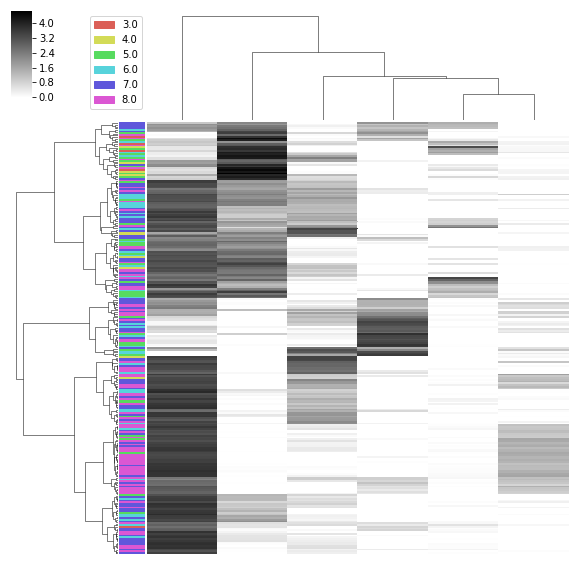

In [15]:
kwargs = dict(
    row_labels=oc_col, 
    xticklabels=False, 
    yticklabels=False,
)
ret = nmfviz.weights_clustermap(nmf.biomarkers, **kwargs)


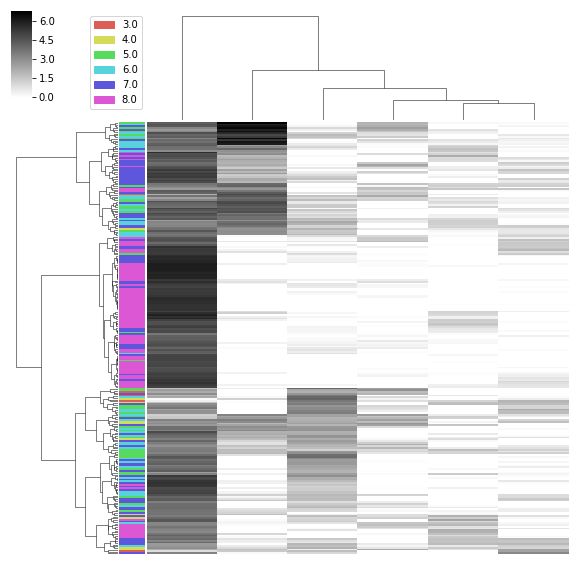

In [16]:
ret = nmfviz.weights_clustermap(nmf.outcomes, **kwargs)